# Import Libraries

In [1]:
# This cell imports all the libraries needed 
from sklearn.metrics.cluster import adjusted_rand_score
from skimage import data, segmentation, color
from skimage import graph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import slic
from skimage.color import rgb2lab
from skimage.segmentation import mark_boundaries
from grakel.kernels import ShortestPath
from grakel import Graph
import scipy.io
import os
import glob
from grakel import GraphKernel
from grakel.kernels import ShortestPathAttr, SubgraphMatching, PropagationAttr
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import cv2
import pickle
from grakel.kernels import WeisfeilerLehman, VertexHistogram, NeighborhoodHash, WeisfeilerLehmanOptimalAssignment, EdgeHistogram
import csv
import statistics
from skimage import io, color
import math
from scipy.stats import wilcoxon

num_images = 200

# Set the random seed
np.random.seed(42)

C:\Users\giwrg\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Helper Functions

In [4]:
def downsample_image(image:np.array)->np.array:
    """ Downsample every image in order to speed up calculations.
        We choose every second pixel -> Reduce size in half. 
    :param image: The original image of type `np.array`.
    :return: Return the same image downsampled half the size. 
    """
    return image[0::2, 0::2]


def load_image(path: str)->np.array:
    """
     Load the image from the specified path. 
     Pixel intensities take values in the range [0,255] and are represented using all 3 channels (RGB). 
     redChannel   = image_imported[:,:,0] - Red channel
     greenChannel = image_imported[:,:,1] - Green channel
     blueChannel  = image_imported[:,:,2] - Blue channel
    
    :param path: The path of the image of type `str`.
    :image_imported : The image stored as `np.array`. 

    """
    image_imported = Image.open(path)
    image = np.array(image_imported)
    image = downsample_image(image)
    return image


def load_ground_truth_images()->dict:
    """ Create a dictionary with groundtruth segmentations for each image in the training set.
    
    :return groundtruth: Dictionary of the form key:[segmentation,number of segments,chosen_truth]. For each image
    we might have more than 1 ground truth segmentations so we will return the segmentation with the MINIMUM 
    number of segments. Key is going to be the number of the image. 
    """
    folder_path = "C:/Users/giwrg/Desktop/Master/Modules/Thesis/Reading Material & Data/2- Data/Data Used - 500/groundTruth/train"  
    # Construct the pattern to match image files
    image_pattern = os.path.join(folder_path, '*.mat')  
    # Use glob to find all matching image file paths
    image_paths = glob.glob(image_pattern)
    train_paths = []
    groundtruth = {}
    # Replace \ with /
    for path in image_paths:
        updated_string = path.rsplit("\\", 1)
        updated_string = "/".join(updated_string)
        train_paths.append(updated_string)

    for path in image_paths:
        mat_path = path
        # Get the file name from the path
        file_name = os.path.basename(path)
        # Remove the file extension
        file_name = os.path.splitext(file_name)[0]
        # Extract the number
        image_number = file_name.split("\\")[-1]

        mat_contents = scipy.io.loadmat(mat_path)
        num_of_groundtruths = mat_contents['groundTruth'][0].shape[0]
        num_regions = []
        for i in range(0,num_of_groundtruths):
            # Find the number of distinct elements
            num_distinct_elements = len(np.unique(mat_contents['groundTruth'][0][i][0][0][0]))
            num_regions.append(num_distinct_elements)
        max_index = num_regions.index(min(num_regions))  # TODO: Modify this accordingly
        selected_truth = mat_contents['groundTruth'][0][max_index][0][0][0]
        # Downsample true segmentation 
        selected_truth = downsample_image(selected_truth)
        groundtruth[image_number] = [selected_truth,len(np.unique(selected_truth)), max_index]
    return groundtruth

    
def superpixel_SLIC(image: np.array, n_segments:int, compactness:int) ->np.array:
    """
    Create superpixels using SLIC algorithm.
    
    
    :param image: Image of type 'np.array' having all 3 channels (RGB format)
    :param n_segments: Approximate number of superpixels of type `int`.
    :param compactness: Defines the tradeoff between space and color proximity of type `int`. 
    High m  -> more square superpixels.
    Small m -> arbitary shapes for superpixels but more sensitive to boundries.
    :return superpixels: The superpixel regions of type 'np.array'.
    """
    
    # Use lab color format
    lab = rgb2lab(image)

    # Use SLIC algorithm for superpixel segmentation
    superpixels = slic(lab, n_segments=n_segments, compactness=compactness, start_label=1)
    return superpixels



def Euclidean_distance(vector_a:list, vector_b:list)->float:
    """ Calculate Euclidean distance between co-ordinates-vectors of 2 pixels. 
    
    :param vector_a: Co-ordinates of first node of type `list`.
    :param vector_b: Co-ordinates of second node of type `list`.
    :return result: Return the Euclidean distance of co-ordinates of type `int`. 
    """
    result = np.sqrt((vector_a[0]-vector_b[0])**2 + (vector_a[1]-vector_b[1])**2)
    return result


def rgb_to_grayscale(rgb):
    """ Compute grayscale value from RGB values. 
    :param rgb: The RGB value of type `list`.
    :return grayscale: The pixel intensity grayscale value in the range [0,255] of type `int`.
    """
    grayscale = int(0.2989 * rgb[0] + 0.5870 * rgb[1] + 0.1140 * rgb[2])
    return grayscale


def edge_labels_calc(vector_a:list, vector_b:list)->str:
    """ Calculate edge labels by concatinating pixel intensity values. 
    
    :param vector_a: RGB values of first node of type `list`.
    :param vector_b: RGB values of second node of type `list`.
    :return: String with edge label.     
    """
    # Convert to grayscale and concatinate. 
    A = rgb_to_grayscale(vector_a)
    B = rgb_to_grayscale(vector_b)
    return str(A)+str(B)
    

def get_image_number(path:str)->str:
    """ Extract image number from path. 
    :param path: The path of the image of type `str`.
    :return image_number: Return the image number of type `str`.
    """
    # Get the file name from the path
    file_name = os.path.basename(path)
    # Remove the file extension
    file_name = os.path.splitext(file_name)[0]
    # Extract the number
    image_number = file_name.split("\\")[-1]
    return image_number


def create_graphs(image: np.array, superpixels: np.array)->list:
    """
    Create a list of Graphs where each graph corresponds to a superpixel. Every node in each graph has
    as attributes the RGB values. Each node is connected with at-most 8 neighboors. 
    
    :param image: Image of type 'np.array' having all 3 channels (RGB format).
    :param superpixels: The superpixel regions of type 'np.array'.
    :return image_graphs: A `list` with graphs for each superpixel. Each graph is an instance of the class
    `Graph` within the Grakel library.  
    """
    num_of_superpixels = len(np.unique(superpixels)) # The number of superpixels-graphs 
    image_graphs = []
    for graph_num in range(1,num_of_superpixels+1):
        indices = np.argwhere(superpixels == graph_num)  # Indices of the pixels which are in the specific superpixel
        adj_matrix = np.zeros((len(indices), len(indices)))  # Adjacency matrix
        node_attributes = {}  # Dictionary with attributes for each vertex.
        examined_vertices = []
        vertex_index = 0
        for vector in indices:
            x_coordinate       = vector[0]
            y_coordinate       = vector[1]
            redChannel_value   = image[x_coordinate,y_coordinate,0] # Red channel pixel value 
            greenChannel_value = image[x_coordinate,y_coordinate,1] # Green channel pixel value
            blueChannel_value  = image[x_coordinate,y_coordinate,2] # Blue channel pixel value
                        
            # Update dictionary with attributes for each vertex
            node_attributes[vertex_index] = [redChannel_value, greenChannel_value, blueChannel_value]
            if examined_vertices == []:  # This is the first vertex to be added
                examined_vertices.append(vector)
                vertex_index = vertex_index + 1
            else:
                # Update adjacency matrix
                for index, existing_vertex in enumerate(examined_vertices):
                    if Euclidean_distance(existing_vertex, vector) < 1.45:  # Use a 8-neighbourhood
                        adj_matrix[index, vertex_index] = 1
                        adj_matrix[vertex_index, index] = 1
                examined_vertices.append(vector)
                vertex_index = vertex_index + 1
        G = Graph(adj_matrix, node_labels=node_attributes)
        image_graphs.append(G)
    return image_graphs


def create_graphs_grayscale(image: np.array, superpixels: np.array)->list[Graph]:
    """
    Create a list of Graphs where each graph corresponds to a superpixel. Every node in each graph has
    as label the grayscale pixel intensity value in the range [0,255]. Each node is connected with at-most 8 neighboors. 
    
    :param image: Image of type 'np.array' having all 3 channels (RGB format).
    :param superpixels: The superpixel regions of type 'np.array'.
    :return image_graphs: A `list` with graphs for each superpixel. Each graph is an instance of the class
    `Graph` within the Grakel library. 
    """
    num_of_superpixels = len(np.unique(superpixels)) # The number of superpixels-graphs 
    image_graphs = []
    for graph_num in range(1,num_of_superpixels+1):
        indices = np.argwhere(superpixels == graph_num)  # Indices of the pixels which are in the specific superpixel
        adj_matrix = np.zeros((len(indices), len(indices)))  # Adjacency matrix
        node_labels = {}  # Dictionary with labels for each vertex.
        examined_vertices = []
        vertex_index = 0
        for vector in indices:
            x_coordinate       = vector[0]
            y_coordinate       = vector[1]
            image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            pixel_intensity    = image_gray[x_coordinate,y_coordinate]
            # Update dictionary with attributes for each vertex
            node_labels[vertex_index] = pixel_intensity
            if examined_vertices == []:  # This is the first vertex to be added
                examined_vertices.append(vector)
                vertex_index = vertex_index + 1
            else:
                # Update adjacency matrix
                for index, existing_vertex in enumerate(examined_vertices):
                    if Euclidean_distance(existing_vertex, vector) < 1.45:  # Use a 8-neighbourhood
                        adj_matrix[index, vertex_index] = 1
                        adj_matrix[vertex_index, index] = 1
                examined_vertices.append(vector)
                vertex_index = vertex_index + 1
        G = Graph(adj_matrix, node_labels=node_labels)
        image_graphs.append(G)
    return image_graphs


def create_graphs_edges(image: np.array, superpixels: np.array)->list:
    """
    Create a list of Graphs where each graph corresponds to a superpixel. Every graph has
    edge weights which correspond to concatinations of pixel intensity values. 
    Each node is connected with at-most 8 neighboors. 
    
    :param image: Image of type 'np.array' having all 3 channels (RGB format).
    :param superpixels: The superpixel regions of type 'np.array'.
    :return image_graphs: A `list` with graphs for each superpixel. 
    """
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate Otsu's threshold
    threshold, _ = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    num_of_superpixels = len(np.unique(superpixels)) # The number of superpixels-graphs 
    image_graphs = []
    for graph_num in range(1,num_of_superpixels+1):
        indices = np.argwhere(superpixels == graph_num)  # Indices of the pixels which are in the specific superpixel
        adj_matrix = np.zeros((len(indices), len(indices)))  # Adjacency matrix
        node_attributes = {}  # Dictionary with attributes for each vertex.
        edges = {}
        edge_labels = {}
        examined_vertices = []
        vertex_index = 0
        for vector in indices:
            x_coordinate       = vector[0]
            y_coordinate       = vector[1]
            redChannel_value   = image[x_coordinate,y_coordinate,0] # Red channel pixel value 
            greenChannel_value = image[x_coordinate,y_coordinate,1] # Green channel pixel value
            blueChannel_value  = image[x_coordinate,y_coordinate,2] # Blue channel pixel value
            
                        
            # Update dictionary with attributes for each vertex
            node_attributes[vertex_index] = [redChannel_value, greenChannel_value, blueChannel_value]
            if examined_vertices == []:  # This is the first vertex to be added
                examined_vertices.append(vector)
                vertex_index = vertex_index + 1
            else:
                # Update adjacency matrix
                for index, existing_vertex in enumerate(examined_vertices):
                    if Euclidean_distance(existing_vertex, vector) < 1.45:  # Use a 8-neighbourhood
                        RGB_1 = node_attributes[index]
                        RGB_2 = node_attributes[vertex_index]
                        adj_matrix[index, vertex_index] = 1
                        adj_matrix[vertex_index, index] = 1
                        edges[(index, vertex_index)] = 1
                        edges[(vertex_index, index)] = 1
                        edge_labels[(index, vertex_index)] = edge_labels_calc(RGB_1, RGB_2)
                        edge_labels[(vertex_index, index)] = edge_labels_calc(RGB_1, RGB_2)
                examined_vertices.append(vector)
                vertex_index = vertex_index + 1
        G = Graph(edges, edge_labels=edge_labels)
        image_graphs.append(G)
    return image_graphs


def convert_seg_to_boundaries(seg:np.array) ->np.array:
    """ Convert segmentation which uses a different number for each segment into boundries which is 
        a numpy array that contains 1 for boundry pixels. 
    
    :param seg: The segmentation in region format of type 'np.array'.
    :return result: The segmentation in boundry format of type `np.array`.
    """
    
    seg_padded = np.pad(seg, ((1, 0), (1, 0)), mode='constant', constant_values=seg[-1, -1])
    dx = cv2.Sobel(seg_padded, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(seg_padded, cv2.CV_64F, 0, 1, ksize=3)
    boundaries = np.abs(dx) + np.abs(dy)
    boundaries = boundaries[:-1, :-1]
    boundaries = cv2.threshold(boundaries, 0, 1, cv2.THRESH_BINARY)[1]
    result = boundaries.astype(np.uint8)

    return result


def evaluate(Predictions: np.array, Human: np.array)->float:
    """ Calculate the F1-score between the predicted boundries and the ground truth. 
    
    :param Predictions: The predicted boundries of type `np.array`.
    :param Human: The human labelled boundries of type `np.array`.
    :return f1score: F1 score which takes values between 0 and 1. Value is rounded to 4 decimal points and the 
    closer the value to 1 the better.
    """
    
    TP = Predictions * Human
    numFP = 0
    numFN = 0
    nrow, ncol = Predictions.shape
    for i in range(nrow):
        for j in range(ncol):
            if (Predictions[i,j] == 1) & (Human[i,j]==0):
                numFP = numFP + 1
            if (Predictions[i,j] == 0) & (Human[i,j]==1): 
                numFN = numFN + 1
    numTP = np.sum(TP)
    f1score = 2 * numTP / (2 * numTP + numFP + numFN)

    return round(f1score, 4)


def Normalised_cuts(image: np.array, thresh_par: int)->np.array:
    """ Apply normalised cuts to image in order to segment it.
    Source: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_ncut.html#sphx-glr-download-auto-examples-segmentation-plot-ncut-py
    
    :param image: The image to be segmented with RGB values of type `np.array`.
    :param thresh_par: The threshold that will be used for cutting of the graph of type `int`.
    :param segmentations: The segmentation of the image of type `np.array`.
    """

    img     = image
    labels1 = segmentation.slic(img, compactness=10, n_segments=800, start_label=1)
    g       = graph.rag_mean_color(img, labels1, mode='similarity')
    segmentations = graph.cut_normalized(labels1, g, thresh=thresh_par)
    return segmentations
    
    
def load_all_ground_truth_images()->dict:
    """ Create a dictionary with groundtruth segmentations for each image in the training set.
    
    :return groundtruth: Dictionary of the form key:[segmentation1,segmentation2,...,segmentationk]. For each image
    we might have more than 1 ground truth segmentations.
    """
    
    folder_path = "C:/Users/giwrg/Desktop/Master/Modules/Thesis/Reading Material & Data/2- Data/Data Used - 500/groundTruth/train"  
    # Construct the pattern to match image files
    image_pattern = os.path.join(folder_path, '*.mat')  
    # Use glob to find all matching image file paths
    image_paths = glob.glob(image_pattern)
    train_paths = []
    groundtruth = {}
    # Replace \ with /
    for path in image_paths:
        updated_string = path.rsplit("\\", 1)
        updated_string = "/".join(updated_string)
        train_paths.append(updated_string)

    for path in image_paths:
        mat_path = path
        # Get the file name from the path
        file_name = os.path.basename(path)
        # Remove the file extension
        file_name = os.path.splitext(file_name)[0]
        # Extract the number
        image_number = file_name.split("\\")[-1]
        mat_contents = scipy.io.loadmat(mat_path)
        num_of_groundtruths = mat_contents['groundTruth'][0].shape[0]
        ground_truths = []
        for i in range(0,num_of_groundtruths):
            selected_truth = mat_contents['groundTruth'][0][i][0][0][0]
            # Downsample true segmentation
            selected_truth = downsample_image(selected_truth)
            ground_truths.append(selected_truth)
        groundtruth[image_number] = ground_truths
    return groundtruth


def original_Images()->dict:
    
    """ Create a dictionary of the form key:value where key = image code and value is the image
    
    
    :return original_images: A dictionary of type `dict` of the form image_number:original_image
    """
    
    folder_path_train = "C:/Users/giwrg/Desktop/Master/Modules/Thesis/Reading Material & Data/2- Data/Data Used - 500/images/train"  
    # Construct the pattern to match image files
    image_pattern = os.path.join(folder_path_train, '*.jpg')  
    # Use glob to find all matching image file paths
    image_paths = glob.glob(image_pattern)
    train_paths = []

    # Print the paths for each image
    for path in image_paths:
        updated_string = path.rsplit("\\", 1)
        updated_string = "/".join(updated_string)
        train_paths.append(updated_string)

    original_images = {}
    for path in train_paths:  
        mat_path = path
        # Get the file name from the path
        file_name = os.path.basename(path)
        # Remove the file extension
        file_name = os.path.splitext(file_name)[0]
        # Extract the number
        image_number = file_name.split("\\")[-1]
        current_image = load_image(path)
        original_images[image_number] = current_image
    return original_images



# Find all segmentations of normalised cuts
def segmentations_Ncuts()->dict:
    """ Find all segmentations using normalised cuts algorithms and store the results 
    in a dictionary of type `dict`. 
    
    :param segmentations_Ncut: A dictionary with the segmentations of Ncut algorithm of the form 
    image_number:segmentation. 
    """

    segmentations_Ncut = {}
    for image_code in original_Images_dict.keys():
        segmentations_Ncut[image_code] = Normalised_cuts(original_Images_dict[image_code]).astype(np.uint8)
        
    return segmentations_Ncut


def calc_score(predicted:dict, truth:dict)->list:
    """ Measure performance using F1 score between the predicted segmentation and the truth.
    
    
    :param predicted: The predicted segmentations of type `dict` of the form key:value where
    key is the image code and value is the predicted segmentation.
    :param truth: The true segmentations of type `dict` of the form key:list[segmentations] where
    key is the image code and list[segmentations] is a list of all the human generated segmentations.
    :return scores: For each image return the maximum F1 score in a `dict` format. The dictionary stores the 
    information in the form image_number: max_F1_score.
    """
    scores = {}
    image_codes = list(truth.keys())
    for code in image_codes:
        truths = truth[code]  # List of all the human segmentations
        prediction = predicted[code]
        max_score = 0
        for human_segmentations in truths:
            # Convert segmentations into boundry formats
            ground_truth_boundry = convert_seg_to_boundaries(human_segmentations)
            image_segmentation_boundry = convert_seg_to_boundaries(prediction)

            # Calculate performance measures 
            score = evaluate(image_segmentation_boundry, ground_truth_boundry)        
    
            if score > max_score:
                max_score = score
            else:
                pass
        scores[code] = max_score
    return scores



# Perform Hyperparameter Tuning -> Threshold

Threshold value:  0.0001

Threshold value:  0.0005

Threshold value:  0.001

Threshold value:  0.005

Threshold value:  0.01

Threshold value:  0.05

Threshold value:  0.1



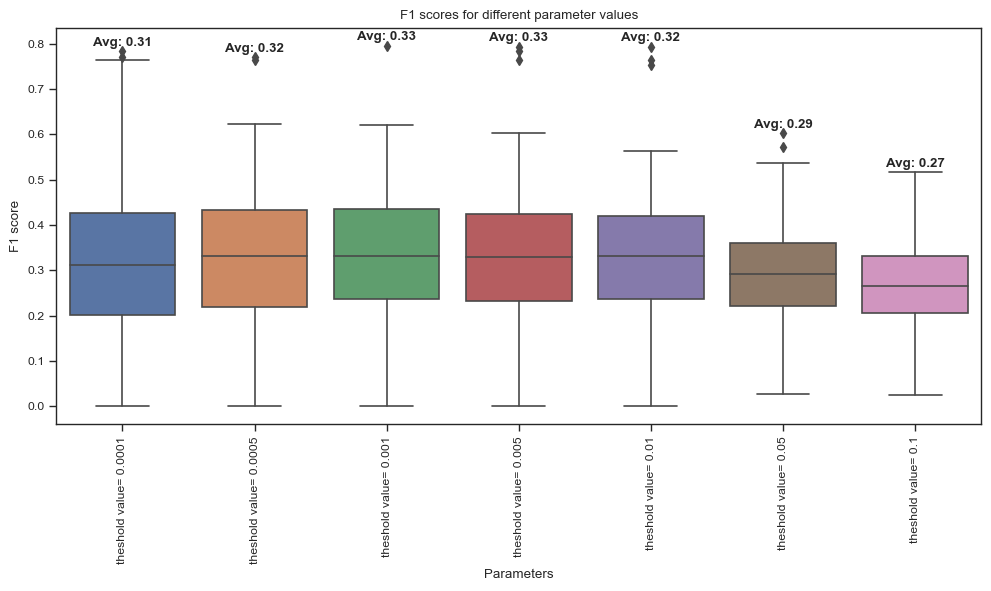

In [5]:
# Select the value of the threshold which has the highest average F1 score among all images in the train set
# For each image we are going to use the human segmentation with the MINIMUM number of segments
# Load the original images 
original_Images_dict = original_Images()
# Load the ground truths for the original images keeping only the ground truth for each image with MIN number of segments. 
load_all_ground_truth_images_dict = load_all_ground_truth_images()
chosen_truths = load_ground_truth_images()


All_F1_scores = []
threshold_values = [0.0001,0.0005,0.001,0.005,0.01,0.05, 0.1]
for threshold_value in threshold_values:
    print('Threshold value: ', threshold_value)
    print()
    F1_scores = []
    segmentations_Ncut = {}
    # Find Segmentations for given threshold value and Ncut algorithm
    for image_code in list(original_Images_dict.keys())[:num_images]:
        segmentations_Ncut[image_code] = Normalised_cuts(original_Images_dict[image_code],threshold_value).astype(np.uint8)
        # Calculate F1 score for each segmentation as the max F1 score across all truths
        truth = load_all_ground_truth_images_dict[image_code]  # Get the list with human segmentations
        chosen_truth = chosen_truths[image_code][2]
        truth = [truth[chosen_truth]]
        prediction = segmentations_Ncut[image_code]  # Get the predicted segmentation
        max_F1_score = 0
        for x in truth:  # Itterate over all human truths
            # Convert to boundries
            ground_truth_boundry = convert_seg_to_boundaries(x)
            image_segmentation_boundry = convert_seg_to_boundaries(prediction)
            # Calculate performance measures 
            score = evaluate(image_segmentation_boundry, ground_truth_boundry) 
            if score > max_F1_score:
                max_F1_score = score
        F1_scores.append(max_F1_score)
    All_F1_scores.append(F1_scores)
    
# Save the list as a pickle file
with open('Ncut_parameters_detailed.pkl', 'wb') as file:
    pickle.dump(All_F1_scores, file)


#####################################################################
####################### Plot Results ################################
#####################################################################

# Load the pickle file with the results
with open('Ncut_parameters_detailed.pkl', 'rb') as file:
    tuning_results = pickle.load(file)
    
# Create a list which stores the parameters of each trial
labels = []
for i in threshold_values:
    labels.append('theshold value= '+ str(i))

# Increase figure size
plt.figure(figsize=(10, 6))
sns.set(style='ticks', context='paper')
# Plot the results
ax = sns.boxplot(data=tuning_results)
ax.set_xticklabels(labels, rotation=90)
plt.title("F1 scores for different parameter values")


# Adding labels and legend
plt.xlabel('Parameters')
plt.ylabel('F1 score')

plt.tight_layout()



# Calculate the average values
averages = [np.mean(category) for category in tuning_results]

# Add average value notations to the top of each box plot
for i, average in enumerate(averages):
    ax.text(i, np.max(tuning_results[i]) + 0.005 , f'Avg: {average:.2f}', ha='center', va='bottom', fontweight='bold')
    
    
